In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gtsa

from gtsa import temporal, plotting, utils

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Load file paths

In [4]:
data_dir    = gtsa.pathlib.Path('/mnt/storage/knuth/sites/scg/hsfm_data/final_products')
dems_fn       = sorted(data_dir.glob('dem*.tif'))
orthos_fn      = sorted(data_dir.glob('ortho*.tif'))

data_dir    = gtsa.pathlib.Path('/mnt/storage/knuth/sites/scg/hsfm_data')
glacier_fn     = data_dir.joinpath('rgi_glacier_oultine.geojson')
reference_dem  = data_dir.joinpath('reference_dem_5m.tif')

assert len(dems_fn) == len(orthos_fn)
assert gtsa.io.parse_timestamps(dems_fn) == gtsa.io.parse_timestamps(orthos_fn)

date_times = [d for d in gtsa.io.parse_timestamps(dems_fn)]
dates = [d.date() for d in date_times]
len(dates)

18

In [5]:
reference_dem = gtsa.gdal.resample_dem(reference_dem, res=10)
# reference_dem = gtsa.pathlib.Path('/mnt/storage/knuth/sites/scg/hsfm_data/reference_dem_30m.tif')

gdalwarp -r cubic -tr 10 10 -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -dstnodata -9999 /mnt/storage/knuth/sites/scg/hsfm_data/reference_dem_5m.tif /mnt/storage/knuth/sites/scg/hsfm_data/reference_dem_5m_10m.tif
Creating output file that is 424P x 491L.
Processing input file /mnt/storage/knuth/sites/scg/hsfm_data/reference_dem_5m.tif.
Using internal nodata values (e.g. -9999) for image /mnt/storage/knuth/sites/scg/hsfm_data/reference_dem_5m.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.



### Stack DEMs

In [6]:
ds = gtsa.io.xr_stack_geotifs(dems_fn,
                              date_times,
                              reference_dem,
                              resampling="bilinear",
                              save_to_nc = False)

Resampled 18 of 18 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.


In [7]:
ma_stack = gtsa.io.np.ma.masked_invalid(ds['band1'].values)
# gtsa.plotting.plot_array_gallery(ma_stack, dates)

In [8]:
X_train = np.ma.array([utils.date_time_to_decyear(i) for i in date_times]).data
test_stack = ma_stack[:,100:150,100:150]

In [9]:
ma_stack.shape

(18, 491, 424)

In [10]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)
X = gtsa.temporal.create_prediction_timeseries(start_date = dates[0].strftime("%Y-%m-%d"),
                                               end_date = dates[-1].strftime("%Y-%m-%d"),
                                               dt ='M')

In [11]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

results = temporal.poly_run_parallel(X_train, valid_data, deg=6)

100%|████████████████████████████████████| 1674/1674 [00:00<00:00, 10178.73it/s]


In [12]:
results.shape

(1674,)

In [13]:
# results = temporal.linreg_run_parallel(X_train, valid_data, method='TheilSen')

In [15]:
# results_stack = temporal.poly_reshape_parallel_results(results, test_stack, valid_mask_2D)

In [13]:
results = temporal.linreg_run_parallel(X_train, valid_data, method='TheilSen')
results_stack = temporal.linreg_reshape_parallel_results(results, test_stack, valid_mask_2D)

slope = results_stack[0]
intercept = results_stack[1]

prediction_stack = np.ma.array([slope*x+intercept for x in X])

100%|█████████████████████████████████████| 1674/1674 [00:00<00:00, 8776.10it/s]


In [14]:
X_dates = [utils.decyear_to_date_time(i).date() for i in X]

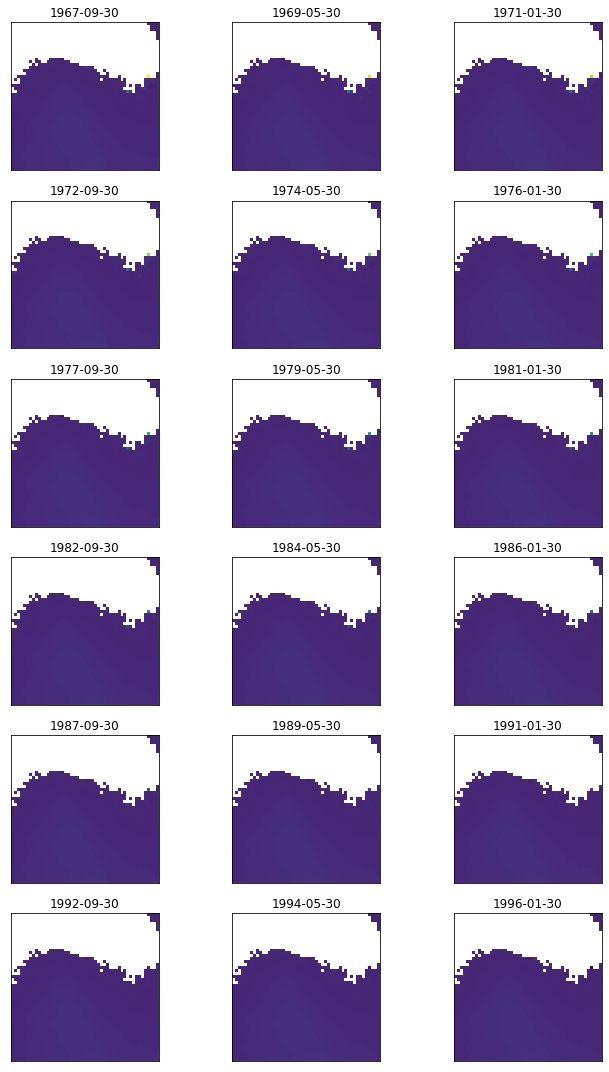

In [15]:
step = 20
plotting.plot_array_gallery(prediction_stack[::step], X_dates[::step])

### Create count and standard deviation maps


In [146]:
count = np.ma.count(ma_stack,axis=0)
count = np.ma.masked_where(count==0,count)
std   = np.ma.std(ma_stack,axis=0)

In [147]:
# put count and std arrays into xarray ds container
count_da = ds['band1'].isel(time=0).drop('time')
count_da.values = count
count_da.name = 'count'

std_da = ds['band1'].isel(time=0).drop('time')
std_da.values = std
std_da.name   = 'std'

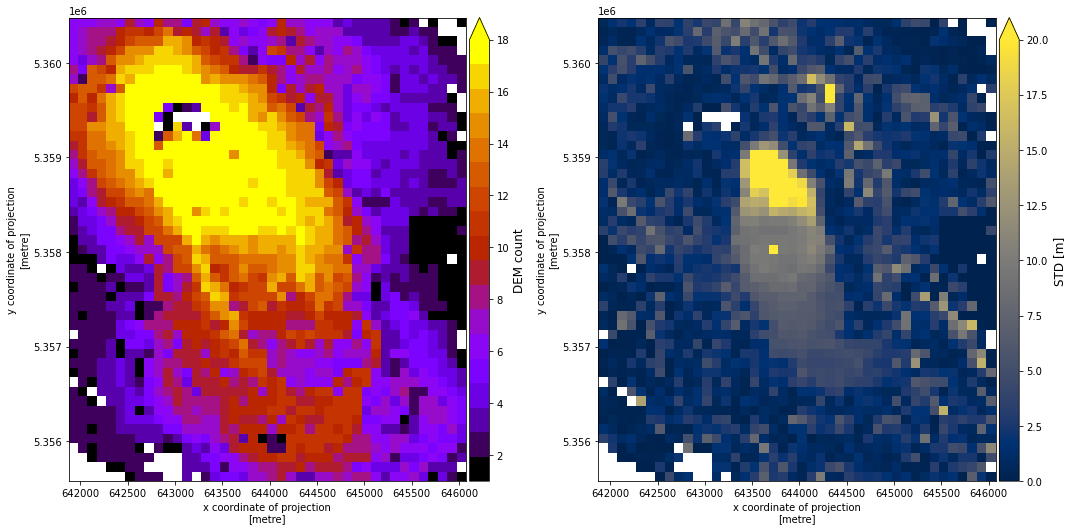

In [148]:
gtsa.plotting.xr_plot_count_std_glacier(count_da,
                                        std_da,
                                        count_vmax=len(dates))

In [149]:
glacier_gdf = gtsa.utils.get_largest_glacier_from_shapefile(glacier_fn)

In [150]:
rgi_id = glacier_gdf['RGIId'].values[0]
flowline_gdf = gtsa.utils.OGGM_get_centerline(rgi_id, crs = ds.rio.crs)

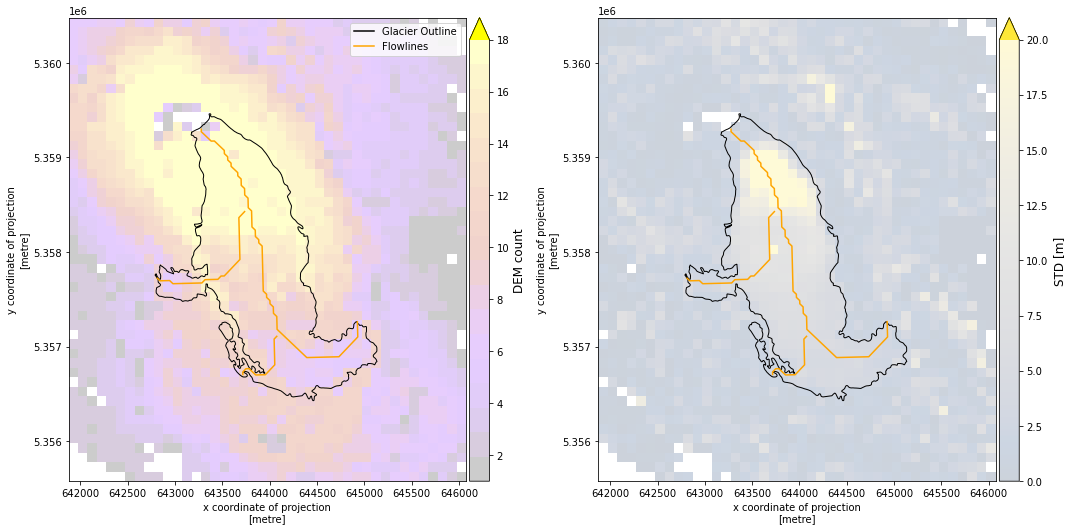

In [151]:
gtsa.plotting.xr_plot_count_std_glacier(count_da,
                                       std_da,
                                       glacier_gdf,
                                       flowline_gdf,
                                       count_vmax=len(dates),
                                       alpha=0.2)

In [152]:
# get vertices of longest segment
longest_segment = flowline_gdf[flowline_gdf['LE_SEGMENT'] == flowline_gdf['LE_SEGMENT'].max()]
points = gtsa.utils.extract_linestring_coords(longest_segment['geometry'].iloc[0])

In [153]:
# select every nth point
step = 5
points = [points[0][::step], points[1][::step]]
print(len(points[0]))

19


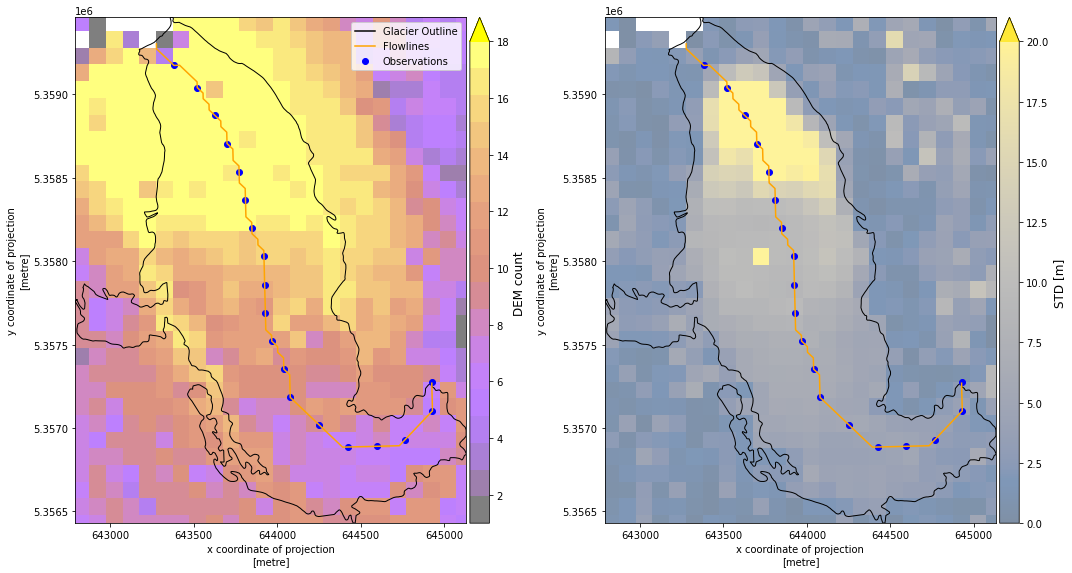

In [154]:
gtsa.plotting.xr_plot_count_std_glacier(count_da,
                                   std_da,
                                   glacier_gdf,
                                   longest_segment,
                                   points=points,
                                   alpha=0.5,
                                        count_vmax=len(dates),
                                   plot_to_glacier_extent=True)

In [155]:
date_time_as_float_array = np.ma.array([gtsa.utils.date_time_to_decyear(i) for i in date_times]).data
test_stack = gtsa.utils.xr_extract_ma_arrays_at_coords(ds['band1'], points[0], points[1])

In [156]:
## remove time series where less available measurements than threshold
n_thresh = 1
test_stack, valid_mask = gtsa.temporal.mask_low_count_pixels(test_stack, n_thresh = n_thresh)
points = [points[0][valid_mask],points[1][valid_mask]]

In [113]:
X_train_data = []
y_train_data = []
for i in range(test_stack.shape[1]):
    X_train, y_train = gtsa.temporal.remove_nan_from_training_data(date_time_as_float_array, test_stack[:,i])
    
    X_train_data.append(X_train)
    y_train_data.append(y_train)

In [114]:
labels = gtsa.plotting.float_x_y_to_int_tuple(points[0],points[1])

In [115]:
y_train_data_mean_sub = []
for i in y_train_data:
    j = i - i.mean()
    y_train_data_mean_sub.append(j)

In [22]:
y_train_data = y_train_data_mean_sub

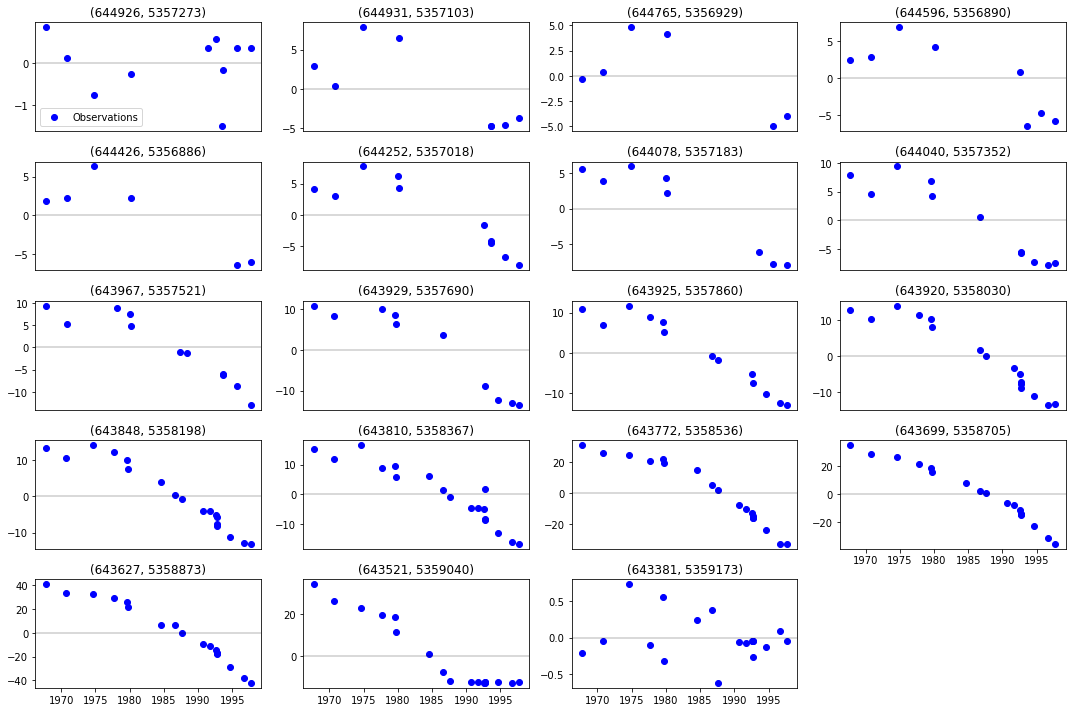

In [23]:
gtsa.plotting.plot_time_series_gallery(X_train_data,
                                       y_train_data, 
                                       sharey=False,
                                       labels = labels)

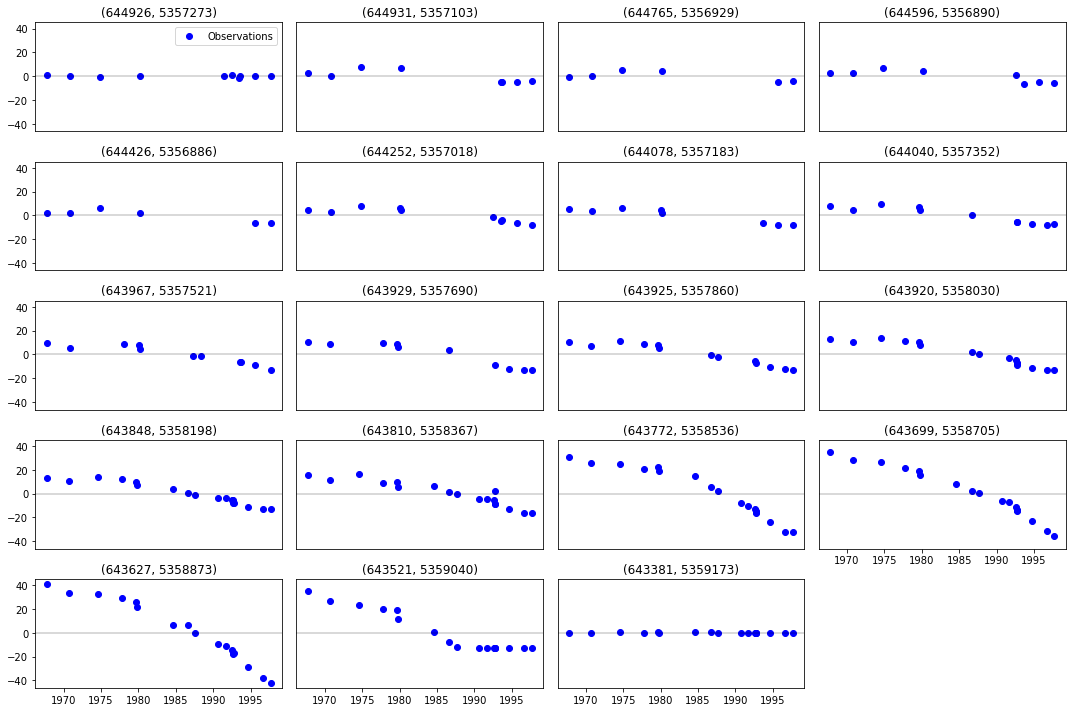

In [24]:
gtsa.plotting.plot_time_series_gallery(X_train_data,
                                       y_train_data, 
                                       labels = labels)

In [116]:
X = gtsa.temporal.create_prediction_timeseries(start_date = dates[0].strftime("%Y-%m-%d"),
                                               end_date = dates[-1].strftime("%Y-%m-%d"),
                                               dt ='M')

In [117]:
x = X_train_data[0]
y = y_train_data[0]

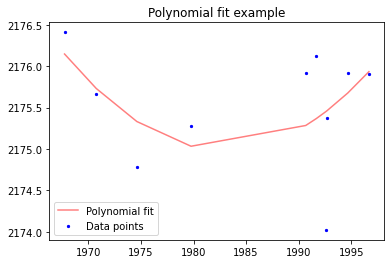

In [118]:
fit = np.polyfit(x, y, 2)
a = fit[0]
b = fit[1]
c = fit[2]
fit_equation = a * np.square(x) + b * x + c
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.plot(x, fit_equation,color = 'r',alpha = 0.5, label = 'Polynomial fit')
ax1.scatter(x, y, s = 5, color = 'b', label = 'Data points')
ax1.set_title('Polynomial fit example')
ax1.legend()
plt.show()

In [119]:
import xdem

In [120]:
x = X_train_data[10]
y = y_train_data[10]

In [121]:
coefs, deg = xdem.fit.robust_polynomial_fit(x,y)
deg

2

In [122]:
func = 0
for i,v in enumerate(coefs):
    func += x**(deg-i)

In [123]:
coeff

array([ 5.92128584e-14,  3.52967003e-12,  3.49772964e-09,  2.31074169e-06,
       -2.33117749e-09,  5.87934058e-13])

In [124]:
coefs

array([-4.08209354e+04,  8.50631135e+01, -2.16638118e-02])

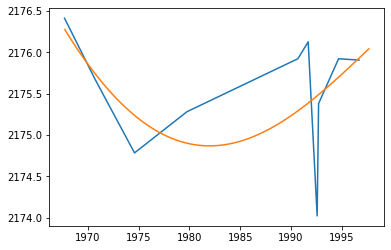

In [136]:
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def _polynomial(x, *p):
    """Polynomial fitting function of arbitrary degree."""
    poly = 0.
    for i, n in enumerate(p):
        poly += n * x**i
    return poly

# # Define some test data:
# x = numpy.linspace(0., numpy.pi)
# y = numpy.cos(x) + 0.05 * numpy.random.normal(size=len(x))

x = X_train_data[0]
y = y_train_data[0]

# p0 is the initial guess for the fitting coefficients, set the length
# of this to be the order of the polynomial you want to fit. Here I
# have set all the initial guesses to 1., you may have a better idea of
# what values to expect based on your data.
p0 = numpy.ones(6,)

coeff, var_matrix = curve_fit(_polynomial, x, y, p0=p0)

# coeff, deg = xdem.fit.robust_polynomial_fit(x,y)
# print(len(coeff))

yfit = [_polynomial(xx, *tuple(coeff)) for xx in X] # I'm sure there is a better
                                                    # way of doing this

plt.plot(x, y, label='Test data')
plt.plot(X, yfit, label='fitted data')

plt.show()

In [110]:
y

masked_array(data=[0.869384765625, 0.12646484375, -0.7587890625,
                   -0.260986328125, 0.3798828125, 0.583740234375,
                   -1.52099609375, -0.162353515625, 0.379638671875,
                   0.363525390625],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20,
            dtype=float32)

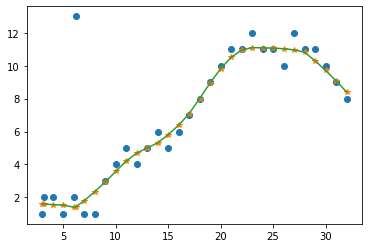

In [59]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = list(range(3, 33)) + [3.2, 6.2]
y = [1,2,1,2,1,1,3,4,5,4,5,6,5,6,7,8,9,10,11,11,12,11,11,10,12,11,11,10,9,8,2,13]

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.3)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(400)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o')
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.show()

In [76]:
x = X_train_data[0]
y = y_train_data[0]

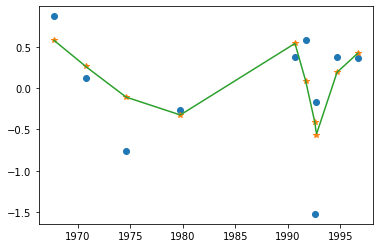

In [77]:
# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.5)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = X

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o')
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.show()

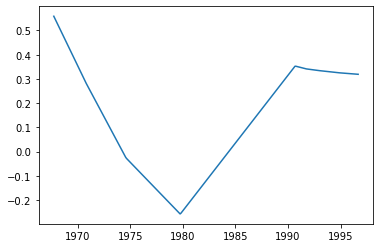

In [70]:
plt.plot(xnew, ynew, '-')

In [379]:
predictions = []

for i,v in enumerate(X_train_data):
    slope, intercept = temporal.linreg_fit(X_train_data[i],
                                           y_train_data[i],
                                           method='Linear')
    prediction = slope*X+intercept
    predictions.append(prediction)
    
LinearReg_df = pd.DataFrame(predictions).T
LinearReg_df.index = X

In [380]:
predictions = []

for i,v in enumerate(X_train_data):
    slope, intercept = temporal.linreg_fit(X_train_data[i],
                                           y_train_data[i],
                                           method='RANSAC')
    prediction = slope*X+intercept
    predictions.append(prediction)
    
RANSAC_df = pd.DataFrame(predictions).T
RANSAC_df.index = X

In [381]:
predictions = []

for i,v in enumerate(X_train_data):
    slope, intercept = temporal.linreg_fit(X_train_data[i],
                                           y_train_data[i],
                                           method='TheilSen')
    prediction = slope*X+intercept
    predictions.append(prediction)
    
TheilSen_df = pd.DataFrame(predictions).T
TheilSen_df.index = X

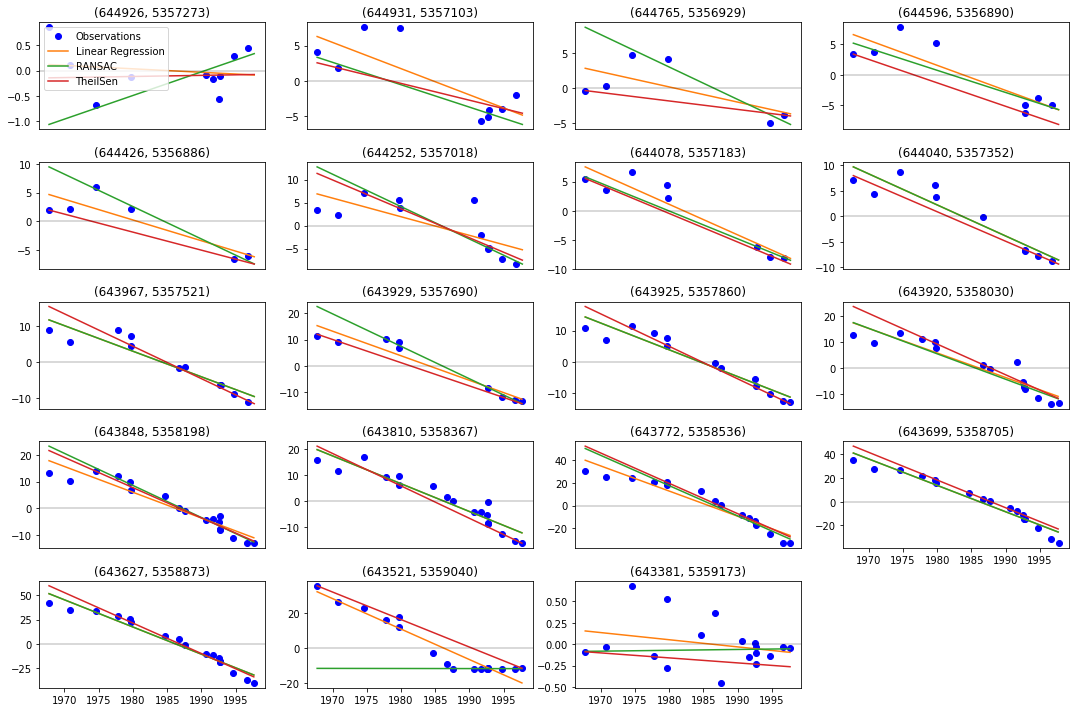

In [382]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[LinearReg_df,RANSAC_df,TheilSen_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen"], 
                                  sharey=False,
                                  labels = labels)

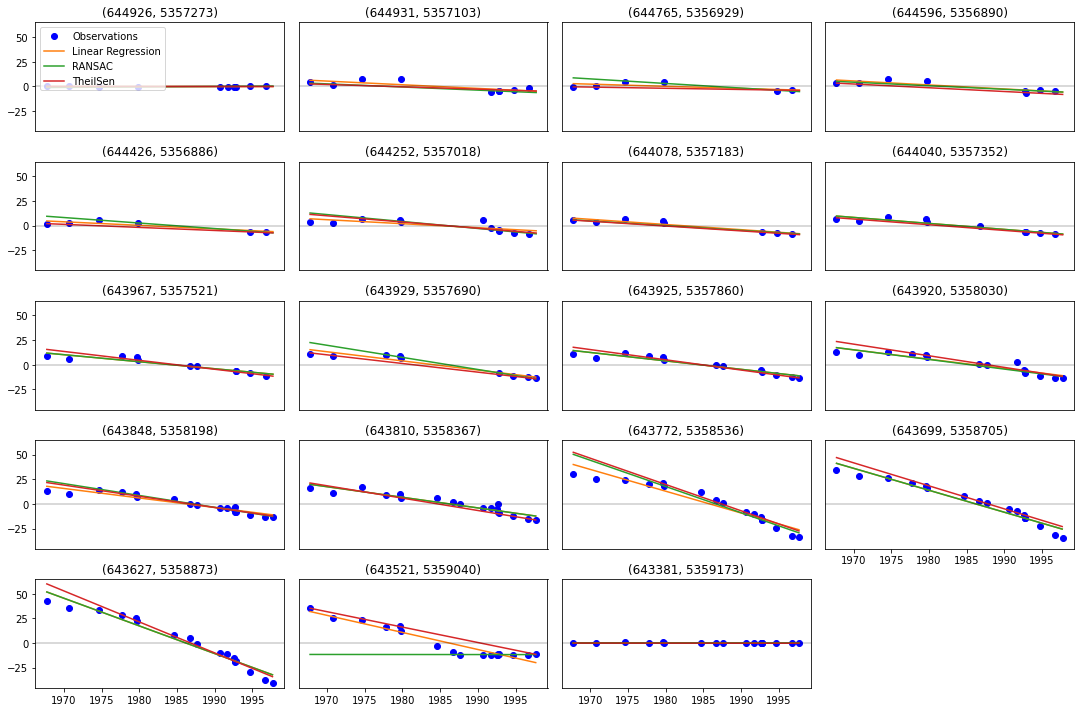

In [383]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[LinearReg_df,RANSAC_df,TheilSen_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen"], 
                                  labels = labels)

In [164]:
glacier_kernel = temporal.GPR_glacier_kernel()

predictions = []
std_predictions = []

for i,v in enumerate(X_train_data):
    gaussian_process_model = temporal.GPR_model(X_train_data[i], y_train_data[i], glacier_kernel, alpha=1e-10)
    mean_prediction, std_prediction = temporal.GPR_predict(gaussian_process_model, X)
    predictions.append(mean_prediction)
    std_predictions.append(std_prediction)
    
GPR_df = pd.DataFrame(predictions).T
GPR_df.index = X

GPR_std_df = pd.DataFrame(std_predictions).T
GPR_std_df.index = X

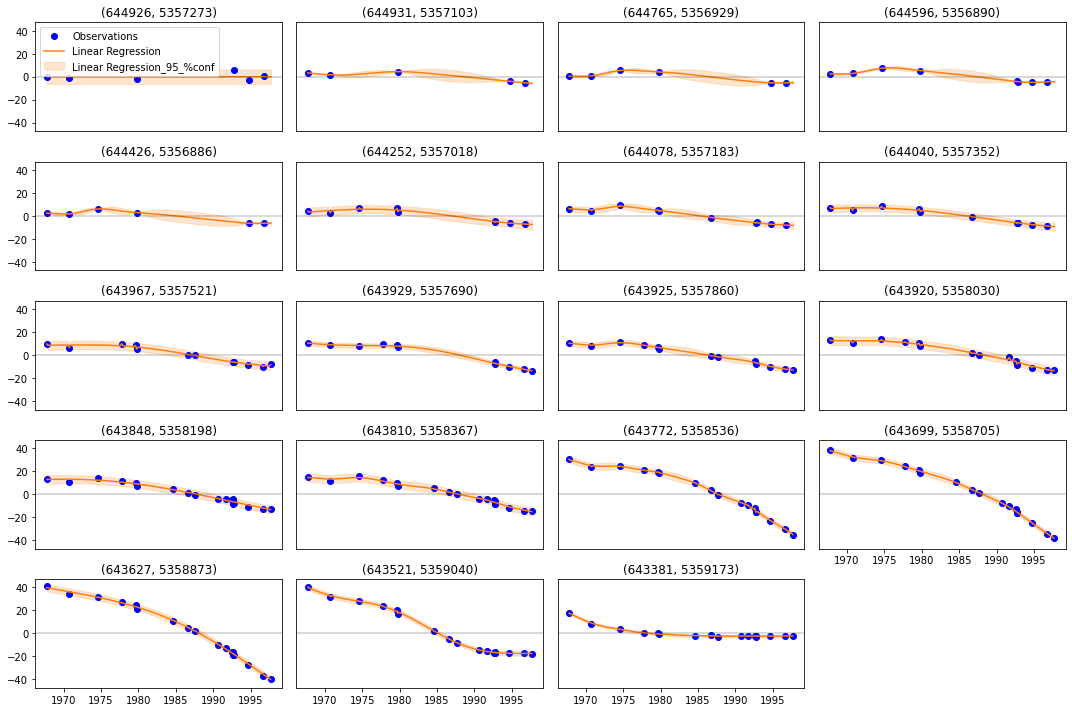

In [165]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[GPR_df],
                                  std_df_list=[GPR_std_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen",
                                                   "GPR"], 
                                  labels = labels)

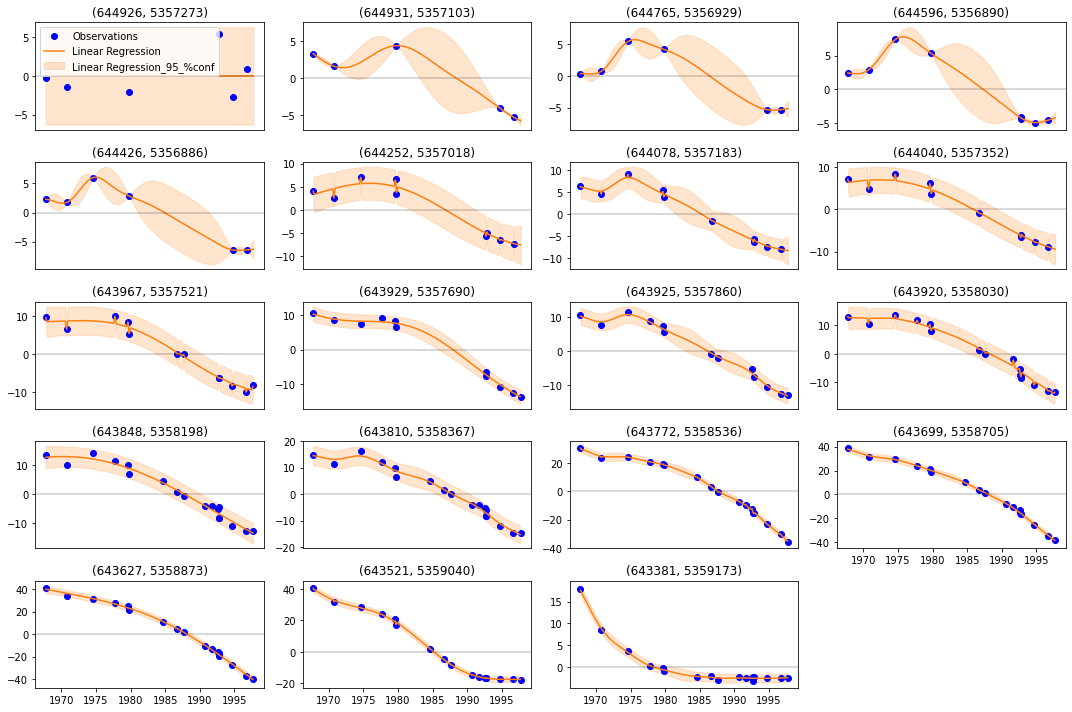

In [166]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[GPR_df],
                                  std_df_list=[GPR_std_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen",
                                                   "GPR"], 
                                  sharey=False,
                                  labels = labels)

In [157]:
X_train = np.ma.array([utils.date_time_to_decyear(i) for i in date_times]).data
test_stack = ma_stack[:,1500:1550,1700:1750]

test_stack = ma_stack[:,50:100,50:100]
test_stack = ma_stack[:,15:25,15:25]

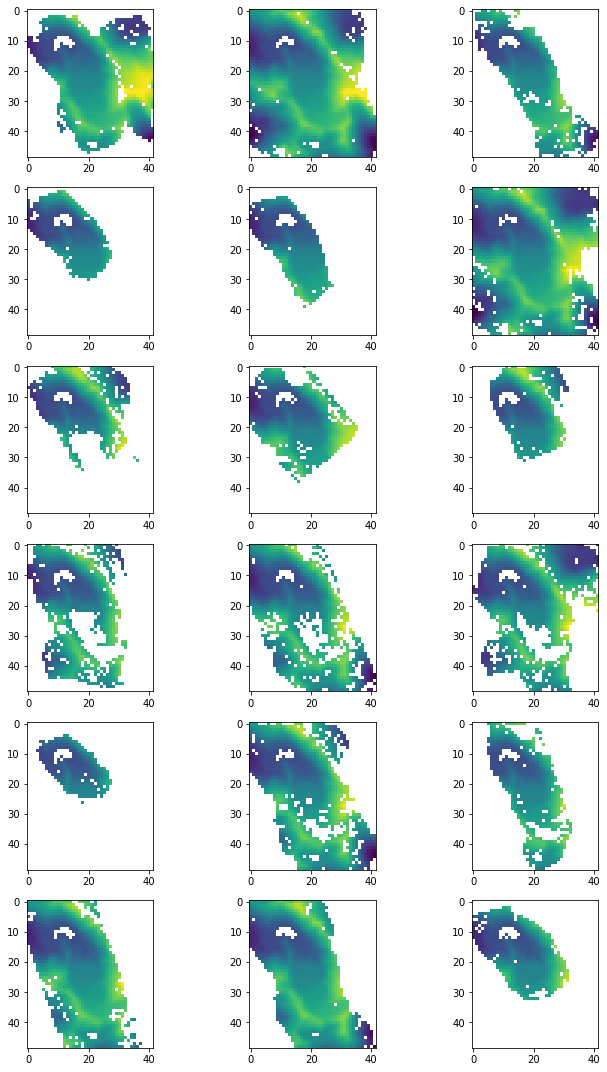

In [158]:
plotting.plot_array_gallery(ma_stack,ticks_on=True)

In [159]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

In [170]:
%%time
results = temporal.GPR_run_parallel(X_train, valid_data, X, glacier_kernel)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.47it/s]


CPU times: user 466 ms, sys: 726 ms, total: 1.19 s
Wall time: 9.88 s


In [171]:
prediction_stack = temporal.GPR_reshape_parallel_results(results, test_stack, valid_mask_2D)

In [443]:
X_dates = [utils.decyear_to_date_time(i).date() for i in X]

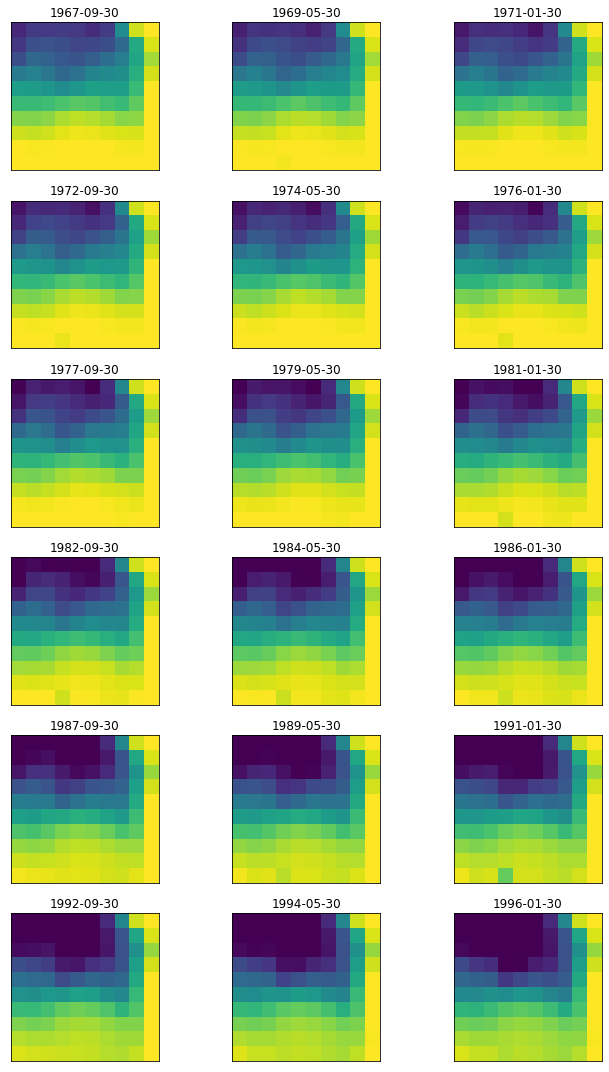

In [173]:
n = 20
plotting.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [174]:
# with np.load('prediction_stack.npz') as npz:
#     arr = np.ma.MaskedArray(**npz)
    
# n = 20
# plotting.plot_array_gallery(arr[::n], X_dates[::n])

In [160]:
test_da = ds['band1'].isel(time=0).drop('time')
test_da.values = count
test_da.name = 'elevation'

In [444]:
with np.load('prediction_stack.npz') as npz:
    prediction_stack = np.ma.MaskedArray(**npz)

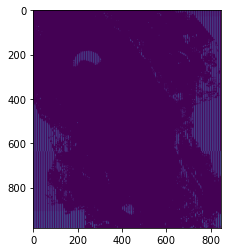

In [445]:
plt.imshow(prediction_stack.data[0])

In [446]:
glacier_gdf = gtsa.utils.get_largest_glacier_from_shapefile(glacier_fn)
X_date_times = [datetime.datetime(t.year, t.month, t.day) for t in X_dates]
datasets=[]
for i,v in enumerate(prediction_stack.data):
    tmp_da = ds['band1'].isel(time=0).drop('time')
    tmp_da.values = v
#     tmp_da.values = tmp_da.rio.clip(glacier_gdf.geometry)
    tmp_da = tmp_da.assign_coords({"time": X_date_times[i]})
    tmp_da = tmp_da.expand_dims("time")
    
    datasets.append(tmp_da)
    
ds_new = gtsa.io.xr.concat(datasets, dim="time", combine_attrs="no_conflicts")

In [447]:
ds_new = ds_new.rio.clip(glacier_gdf.geometry)

In [448]:
datasets=[]

for i,v in enumerate(ds_new):
    try:
        tmp_da = ds_new[i+1] - v
        tmp_da = tmp_da.assign_coords({"time": X_date_times[i]})
        tmp_da = tmp_da.expand_dims("time")
    except:
        pass
    datasets.append(tmp_da)
    
    
ds_new = gtsa.io.xr.concat(datasets, dim="time", combine_attrs="no_conflicts")

In [449]:
ds_new = ds_new.fillna(0)

In [450]:
ds_new = ds_new.where((ds_new > -100.) & (ds_new < 100.), 0) 

In [451]:
for i,v in enumerate(net):
    if v > 1000:
        print(i)
        break

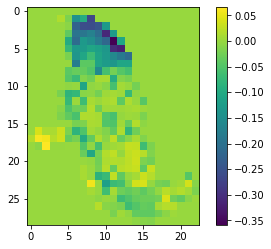

In [452]:
plt.colorbar(plt.imshow(arr[22]))

In [453]:
arr = ds_new.values

In [454]:
arr.max()

87.11255

In [455]:
net = []
for i in arr:
    net.append(np.sum(i.flatten()))

In [456]:
net_new = []
for i in net:
    if i >100 or i <-100:
        pass
    else:
        net_new.append(i)

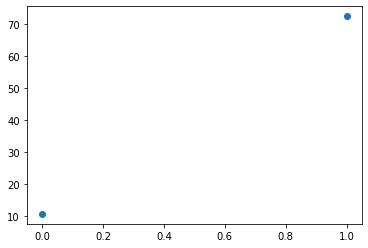

In [457]:
plt.scatter(np.arange(len(net_new)), net_new)

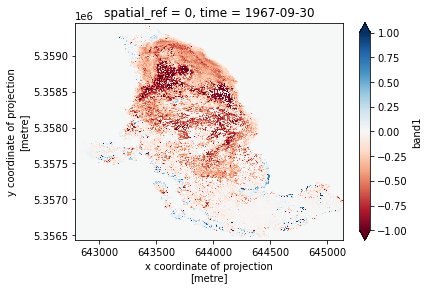

In [458]:
ds_new[0].plot(vmin=-1,vmax=1,cmap='RdBu')

In [459]:
arr = ds_new.data

In [469]:
gtsa.plotting.plot_timelapse(arr, 
                             vmin=-1,
                             vmax=1,
                             cmap='RdBu',
                             titles_list = X_dates,
                             output_file='test_10m.mp4')

In [8]:
temporal.linreg_run_parallel?